# K-Means Clustering on the data set

## Libraries

In [614]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
from matplotlib import pyplot as plt
import random
#random.seed(1)
from sklearn.preprocessing import normalize

## Importing the data set
Our dataset contains images of the **HAM10000** dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions.

In [615]:
# IMPORTANT: Filepath depends on OS!
filepath = r'data/hmnist_28_28_L.csv'
df = pd.read_csv(filepath)
print(df) # Shape (#images, h*w+1) (here: (10015, 785))

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0            169        171        170        177        181        182   
1             19         57        105        140        149        148   
2            155        163        161        167        167        172   
3             25         71        116        139        136        153   
4            129        162        181        196        205        208   
...          ...        ...        ...        ...        ...        ...   
10010        172        171        173        175        164        187   
10011          2         34        108        116        114        119   
10012        122        154        162        170        179        197   
10013        137        143        141        139        147        152   
10014        149        157        157        152        151        152   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0775  pixel0776  \
0            181   

## Displaying an image

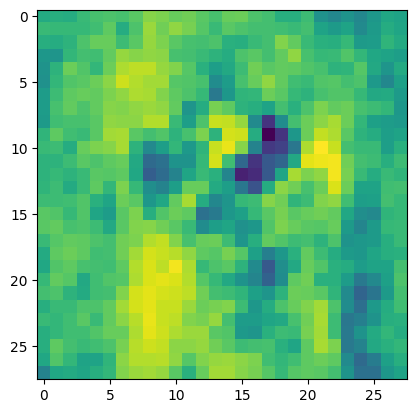

(785,)
pixel0000    169
pixel0001    171
pixel0002    170
pixel0003    177
pixel0004    181
            ... 
pixel0780    140
pixel0781    140
pixel0782    159
pixel0783    165
label          2
Name: 0, Length: 785, dtype: int64


In [673]:
def disp_img(data_vec, colorbar=False):
    # Handle the cases of whether the label for an image is provided or not
    if math.sqrt(np.size(data_vec)) != int(math.sqrt(np.size(data_vec))):
        img_label = data_vec[-1]
        img_vec = data_vec[0:-1]
    else:
        img_vec = data_vec

    size = np.size(img_vec)
    dimension = int(math.sqrt(size))

    img_mat = np.reshape(np.array(img_vec), (dimension, dimension))

    plt.imshow(img_mat)
    if colorbar:
        plt.colorbar()
    plt.show()


img_number = 0 # Index of a particular data image
data_vec = df.loc[img_number]

disp_img(data_vec)

print(data_vec.shape)
print(data_vec)

## Count occurences of labels

Count the number of data images corresponding to each label.

In [617]:
label = df['label']
uniq_label, counts_label = np.unique(label, return_counts=True)

# Each tuple will contain a label and the number of images with the same label
# [(label, #occurences), ..]
occurences = list(zip(uniq_label, counts_label))
print(occurences)

num_cath = len(uniq_label)

[(0, 327), (1, 514), (2, 1099), (3, 115), (4, 6705), (5, 142), (6, 1113)]


# Partition the images into the different classes
Create a list of nested lists. Each nested list represents a label and contains the indices of all data images with the same label. E.g. img_index_group[2] contains all images for label 2.

In [642]:
# List of 7 nested lists (for each diagnostical categorie)
# The ith nested list contains the indices of all images, which correspond to label i
# E.g. img_index_group[2] contains all images for label 2
img_index_group = []

for i in range(num_cath):
    img_index_group.append([])
    for j in range(df.shape[0]):
        if df['label'][j] == i:
            img_index_group[i].append(j)


# Output would exceed the size limit
# print(img_index_group)

# For debugging purposes
# print(list((i, len(img_index_group[i])) for i in range(len(img_index_group))))

[[9687, 9688, 9689, 9690, 9691, 9692, 9693, 9694, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9714, 9715, 9716, 9717, 9718, 9719, 9720, 9721, 9722, 9723, 9724, 9725, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9743, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 98

## Visualizing one Image of each Cathegory

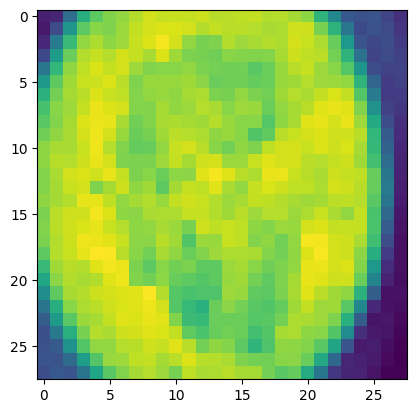

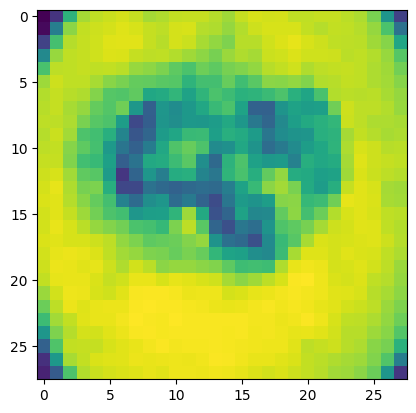

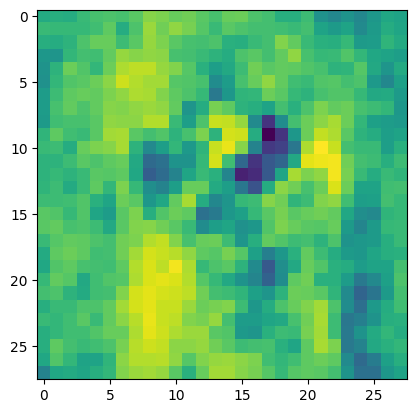

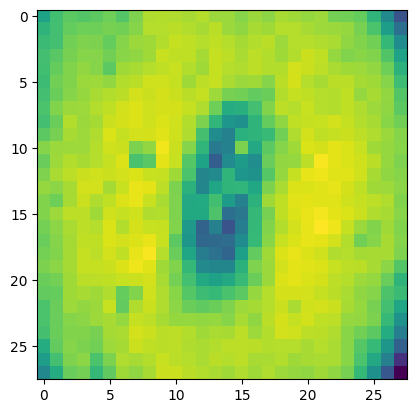

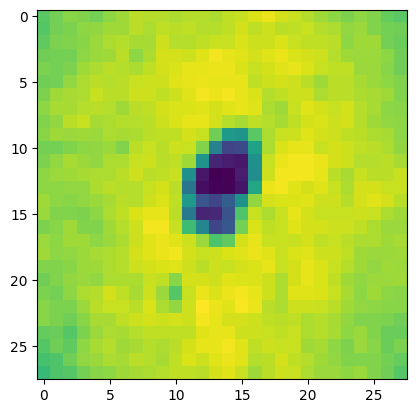

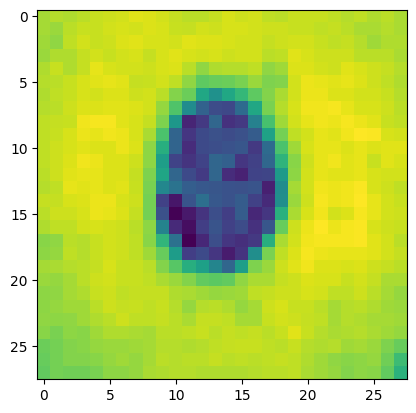

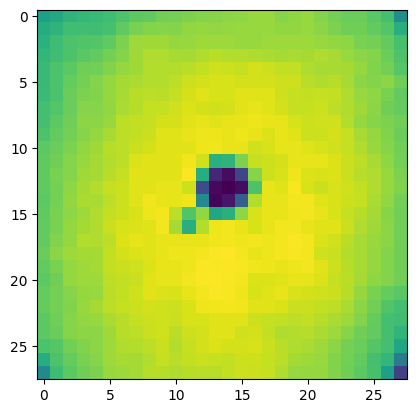

In [674]:
for i in range(len(img_index_group)):
    disp_img(df.iloc[img_index_group[i][0]])

# Splitting into training and testing data

In [619]:
training_split = 0.9                #Percentage of Data used for training
img_index_group_split = []          #Same as img_index_group but every nested list is split into two lists: first is list for training, second is list for testing

for i in range(num_cath):
    random.shuffle(img_index_group[i])
    split_point = round(len(img_index_group[i])*training_split)
    img_index_group_split.append([img_index_group[i][:split_point], img_index_group[i][split_point:]])
    
    #print(i)
    #print(len(img_index_group_split[i][0]))
    #print(len(img_index_group_split[i][1]))

print(img_index_group_split)

[[[9796, 9946, 9918, 9900, 9718, 9745, 9951, 9943, 9743, 9691, 10010, 9942, 9945, 9880, 9892, 10005, 9985, 9874, 9811, 9965, 9971, 9907, 9893, 10001, 9930, 9972, 9941, 9725, 9772, 9727, 9798, 9802, 9729, 9990, 9825, 9977, 9976, 9905, 9926, 9851, 9855, 9991, 9843, 9823, 9869, 9762, 9801, 9929, 9749, 9815, 9751, 9732, 9996, 9922, 9816, 9898, 9804, 9792, 9758, 9939, 9694, 9771, 9949, 9773, 9707, 9877, 9692, 9837, 9724, 9698, 9891, 9989, 9963, 9966, 9735, 9889, 9917, 9978, 9844, 9848, 9994, 9791, 9953, 9805, 9799, 9765, 9746, 9974, 9867, 9759, 9830, 9866, 9992, 9714, 9997, 9902, 9807, 9847, 9910, 9723, 9760, 9741, 9841, 9689, 9788, 9984, 9849, 9822, 9813, 9962, 9908, 9870, 9887, 9895, 9775, 9865, 9763, 9934, 9858, 9931, 9913, 9766, 9835, 9736, 9814, 9789, 10009, 9700, 9832, 9779, 9752, 9782, 9818, 9988, 9715, 9834, 9709, 9879, 9785, 9774, 9737, 9730, 9734, 9702, 9981, 10006, 9710, 9884, 9950, 9982, 9711, 9826, 9924, 10004, 9901, 9854, 9956, 9828, 9731, 9831, 9810, 9964, 9899, 9787, 10013, 

## Merging the different training data sets into one

In [620]:
df_train = pd.concat((df.iloc[img_index_group_split[i][0]] for i in range(num_cath)))
#df_train.sort_index(axis=0, inplace=True)
print(df_train)

      pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
9796        149        155        166        174        174        175   
9946         89         98         99        109        124        132   
9918        172        174        175        176        177        174   
9900        172        183        178        171        173        184   
9718        125        120        116        161        178        170   
...         ...        ...        ...        ...        ...        ...   
1943        177        179        180        176        176        179   
2008        166        171        162        158        169        179   
2044        239        240        239        241        247        248   
1390         86        125        132        131        131        133   
1908        187        189        193        194        194        191   

      pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0775  pixel0776  \
9796        172        161      

## K-Means Clustering

In [621]:
def calcSqDistances(data, Kmus):
    return ((-2 * data.dot(Kmus.T) + np.sum(np.multiply(Kmus,Kmus), axis=1).T).T + np.sum(np.multiply(data, data), axis=1)).T


def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]


def recalcMus(data, Rnk):
    return (np.divide(data.T.dot(Rnk), np.sum(Rnk, axis=0))).T



classes = num_cath # Number of diagnostical categories
max_iterations = 10000000


images = df_train.to_numpy()
# Remove the labels
images = images[:, 0:-1]  # arr: Shape: (#images, #pixels)

n = images.shape[0]
dim = images.shape[1]

# Initialize cluster centers by randomly picking points from the data
rndinds = np.random.permutation(n)
k_mus = images[rndinds[:classes]]


for iter in range(max_iterations):
    sqDmat = calcSqDistances(images, k_mus)
    rank = determineRnk(sqDmat)
    k_mus_old = k_mus
    k_mus = recalcMus(images, rank)

    if sum(abs(k_mus_old.flatten() - k_mus.flatten())) < 1e-6:
        break


# for i in range(classes):
#     disp_img(k_mus[i])

## Calculating the actual means of each cathegorys training data

In [622]:
mean = []

for i in range(num_cath):
    mean.append(np.mean(df_train.loc[img_index_group_split[i][0]].iloc[:, :-1], axis=0))

    #print(mean[i])

## Compare the computed means with the actual means
The mean images computed using the K-means algorithm are on the lefthand side of each plot. The actual means for each label are on the righthand side.

This is just a random pairing and not matched yet

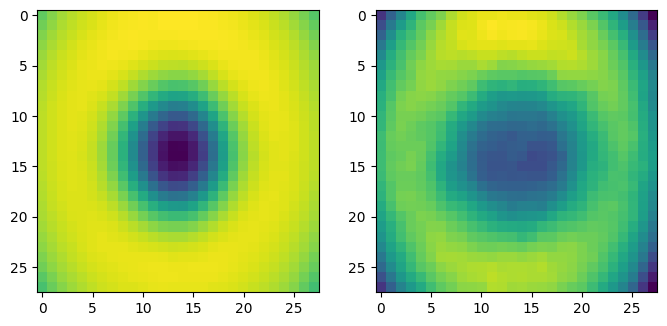

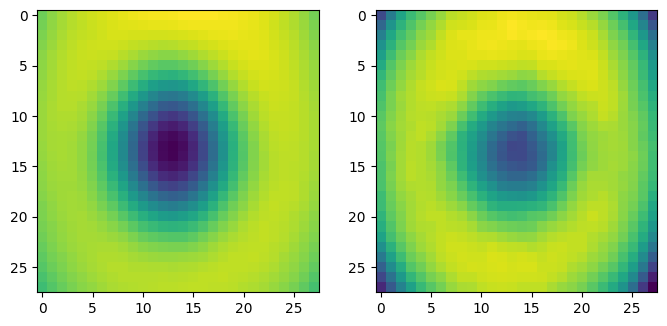

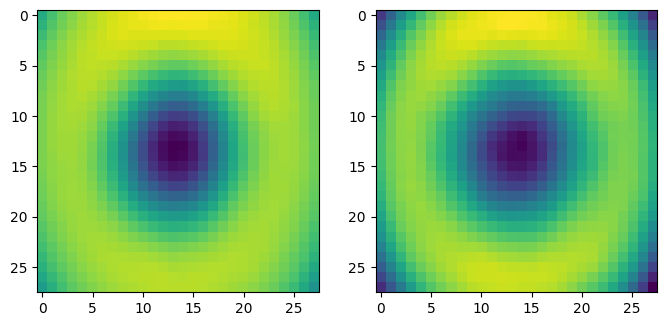

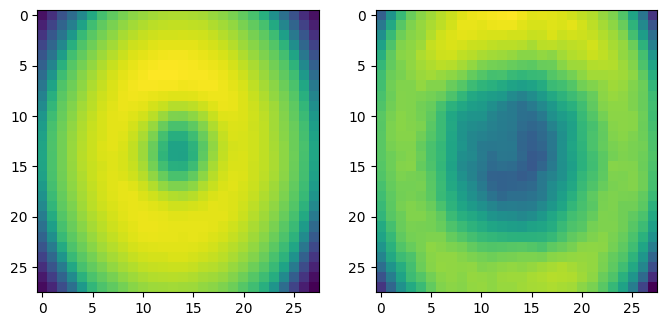

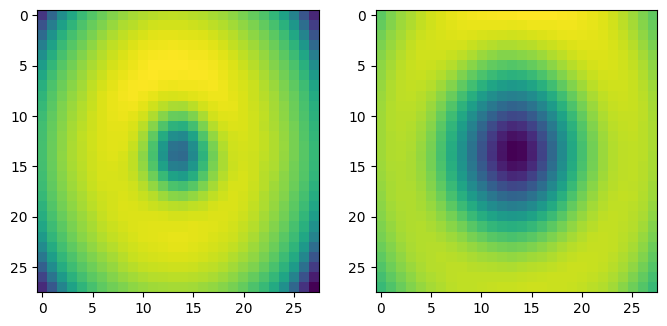

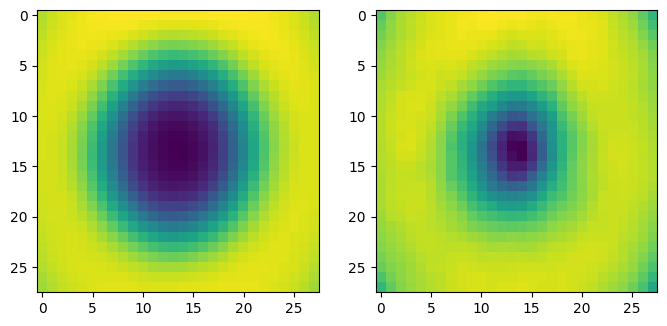

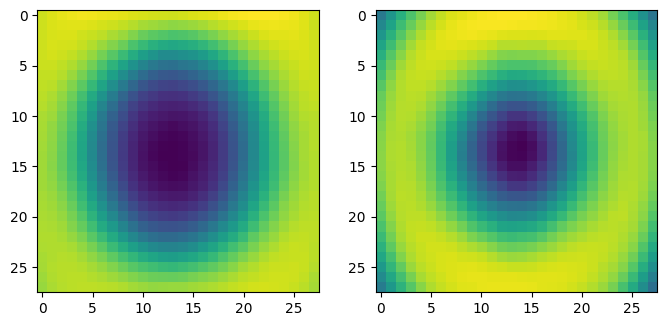

In [652]:
size = int(math.sqrt(len((k_mus[0]))))
for i in range(num_cath):
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(k_mus[i], (size, size)))
    plt.subplot(1, 2, 2)
    disp_img(mean[i])

## Matching the calculated clusters to the different diagnosis

Calculating the MSE for every calculated mean with every actual mean

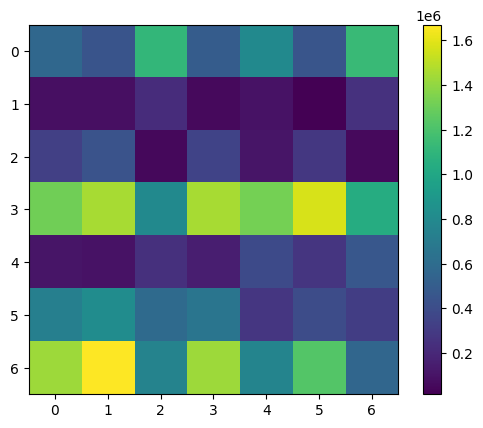

In [624]:
MSE = np.empty([len(mean), len(k_mus)])
for i in range(len(mean)):
    for j in range(len(k_mus)):
        MSE[j][i] = ((mean[i] - k_mus[j]).transpose().dot(mean[i] - k_mus[j]))

df_MSE = pd.DataFrame(MSE)

disp_img(df_MSE, colorbar=True)

Function to Calculate the Mapping from the MSE Martix

Searches for a Mapping between the k_mus and the real means under to condition to minimize the total MSE of that mapping

To achieve a bijective mapping it lets a random k_mus "pick" its cheapest map and the removes it from the pool of possibilities for the other k-mus

Then the next random k_mus "picks" from the remaining pool of possibilities until all k_mus have "picked" their mapping

To try to achieve a global MSE Minimum it iterates iter times over this random selection process and picks the mapping with the lowest cost

Returns a vector $$x = [a, b, c, d, e, f, g]$$ with the mapping, meaning $$k_{mus}[i] \rightarrow mean[x[i]]$$

In [625]:
def find_mapping(df_MSE, iter=1000):     
    mappings = {}
    mappings['Map'] = []
    mappings['Cost'] = []
    for i in range(iter):
        mapping = []
        mean_list = list(range(len(mean)))
        mus_list = list(range(len(k_mus)))

        while len(mus_list) != 0:
            i = random.choice(mus_list)
            min_idx = df_MSE.iloc[i][mean_list].idxmin()
            mapping.append(min_idx)
            mean_list.remove(min_idx)
            mus_list.remove(i)

        cost = 0
        for i in range(len(mapping)):
            cost = cost + MSE[i][mapping[i]]

        mappings['Map'].append(mapping)
        mappings['Cost'].append(cost)

    min_index = mappings['Cost'].index(min(mappings['Cost']))

    df_matching = mappings['Map'][min_index]

    return mappings['Map'][min_index]

Calling the find_mapping function and displaying the real mean and corresponding k_mus next to each other

[1, 5, 6, 2, 3, 0, 4]


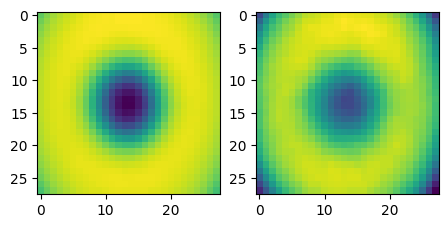

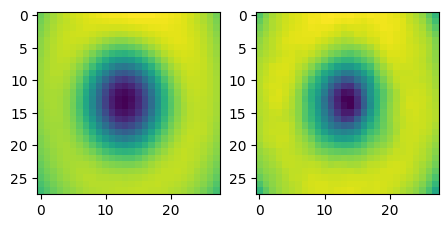

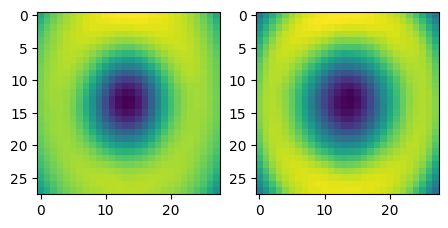

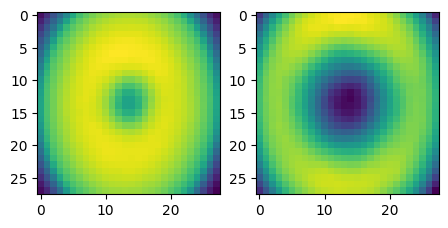

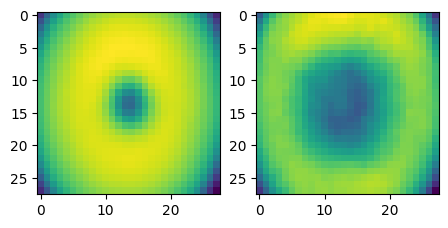

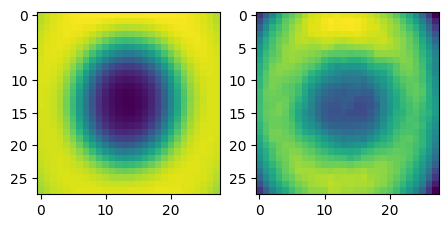

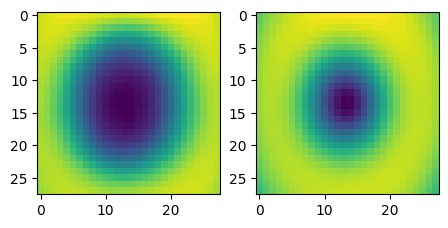

In [626]:
df_matching = find_mapping(df_MSE)
print(df_matching)

for i in range(num_cath):
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(np.reshape(k_mus[i], (size, size)))
    plt.subplot(1, 3, 2)
    disp_img(mean[df_matching[i]])

## Feeding the training data and calculating the accuracy

In [627]:
def evaluate(): 
    right = 0
    wrong = 0

    for k in range(num_cath):
        for j in range(len(df.iloc[img_index_group_split[k][1]])):
            img = df.iloc[img_index_group_split[k][1]].iloc[j]
            img_label = img[-1]
            img_vec = img[0:-1]

            error = np.empty(num_cath)
            for i in range(num_cath):
                error[i] = (k_mus[i] - img_vec).transpose().dot(k_mus[i] - img_vec)

            idx_mu = error.argmin()
            guess = df_matching[idx_mu]
            
            if guess == img_label:
                right += 1
            else:
                wrong += 1

    accuracy = right/(right+wrong)

    return accuracy

print(evaluate())

0.15284715284715283
